# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 
from skimage import data, io
from skimage.filters.rank import median

# Convert colored images to grayscale
<b>grayscale value = 0.33R + 0.33G + 0.33B</b>

In [2]:
def convert_to_grayscale(img):
    new_img = np.zeros((img.shape[0],img.shape[1]), dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img[i][j] = (img[i][j][0]*0.33) + (img[i][j][1]*0.33) + (img[i][j][2]*0.33)
            new_img[i][j] = int(new_img[i][j])
                
    return new_img;

In [3]:
def threshold(img, th):
    result = np.zeros(img.shape, dtype= np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            val = img[i][j]
            if val > th:
                result[i][j] = 255;
    return result

# Focus only on regions of interest in the image

In [4]:
def img_and(img,operand):
    new_img = np.zeros(img.shape, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if operand[i][j] != 0:
                new_img[i][j] = img[i][j]
    return new_img

def remove_disturbance(img):
    logical_operand = io.imread('logical_operand.png')
    logical_operand = convert_to_grayscale(logical_operand)
    return img_and(img,logical_operand)

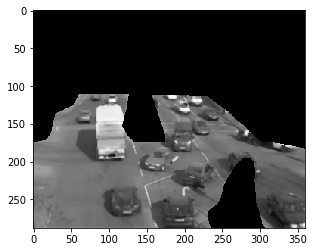

In [5]:
frame1 = io.imread('frame3.png')
frame2 = io.imread('frame4.png')


frame1_gray = convert_to_grayscale(frame1);
frame2_gray = convert_to_grayscale(frame2);


frame1_smooth = median(frame1_gray, np.ones((3,3))/9)
frame2_smooth = median(frame2_gray, np.ones((3,3))/9)


frame1_focussed = remove_disturbance(frame1_smooth)
frame2_focussed = remove_disturbance(frame2_smooth)


plt.imshow(frame1_focussed, 'gray')

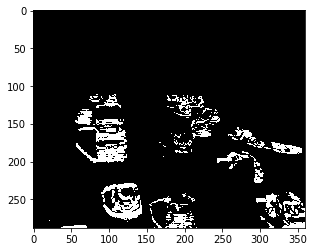

In [6]:
def frame_difference(f1,f2):
    result = np.zeros(f1.shape, dtype=np.uint8)
    for i in range(f1.shape[0]):
        for j in range(f2.shape[1]):
            new_val = abs(int(f2[i][j]) - int(f1[i][j])) #change uint8 to int and allow -ve values
            if new_val > 0: #threshold to remove noise
                result[i][j] = new_val;
    return result


frame1_focussed = remove_disturbance(frame1_focussed)
frame2_focussed = remove_disturbance(frame2_focussed)


moving_objects = frame_difference(frame1_focussed, frame2_focussed)
moving_objects = threshold(moving_objects, 10)

plt.imshow(moving_objects, 'gray')

# Extract all vehicles

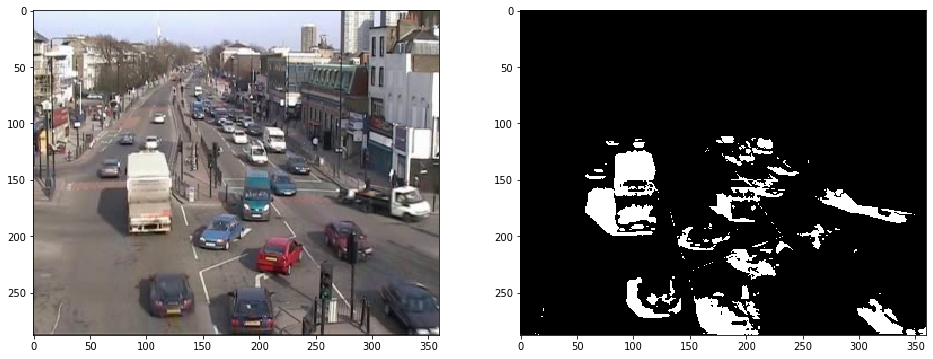

In [7]:
background = io.imread('background.png')
background = convert_to_grayscale(background)
background = remove_disturbance(background)

def extract_foreground(img,background):
    result = np.zeros(img.shape, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            result[i][j] = abs(int(frame1_focussed[i][j]) - int(background[i][j]))
    return result

foreground = extract_foreground(frame1_focussed,background)
foreground = threshold(foreground,50)

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 8)
ax1.imshow(frame1 ,cmap=plt.cm.gray)
ax2.imshow(foreground ,cmap=plt.cm.gray)


plt.show()

# Region Seperation

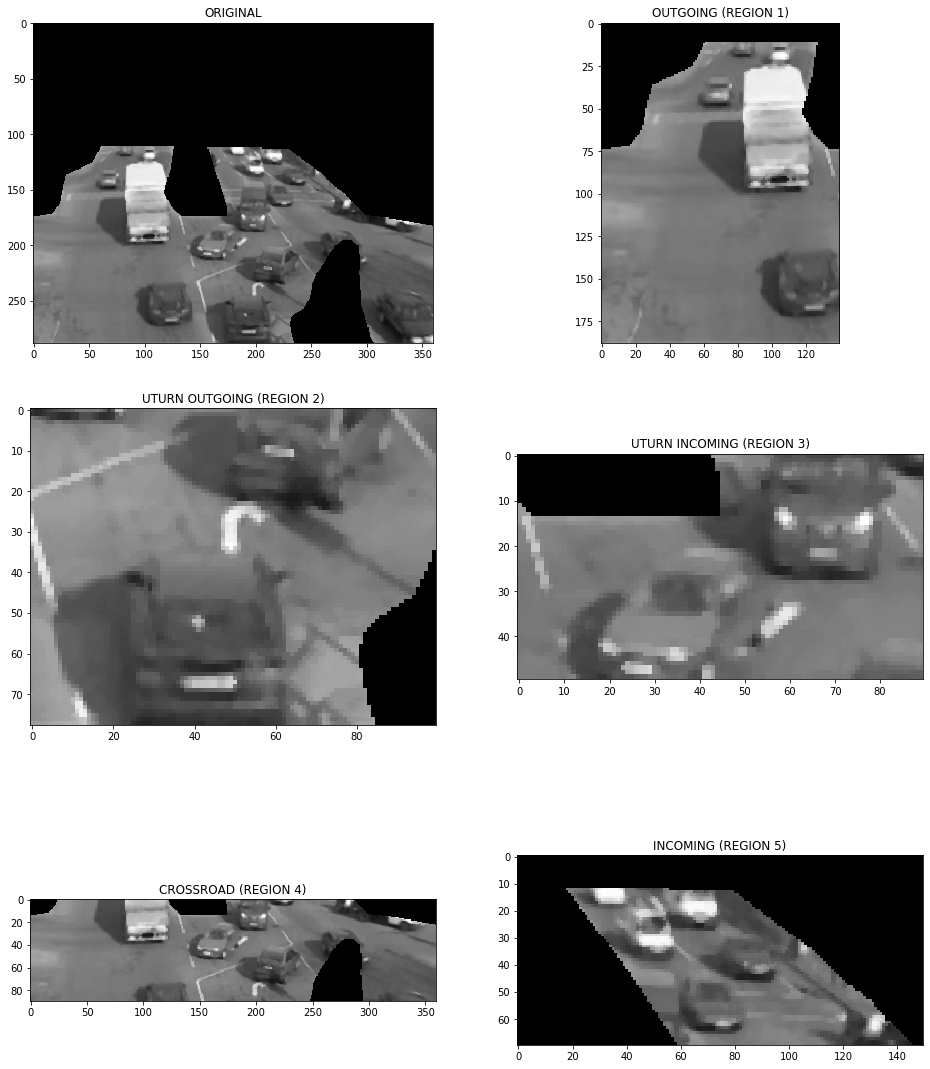

In [8]:
def crop_first_region(imgs):
    cropped_imgs = []
    for img in imgs:
        cropped_imgs.append(img[100:,0:140])
    return cropped_imgs

def crop_second_region(imgs):
    cropped_imgs = []
    for img in imgs:
         cropped_imgs.append(img[210:,150:250])
    return cropped_imgs

def crop_third_region(imgs):
    cropped_imgs = []
    for img in imgs:
        cropped_imgs.append(img[160:210,130:220])
    return cropped_imgs

def crop_fourth_region(imgs):
    cropped_imgs = []
    for img in imgs:
        cropped_imgs.append(img[160:250,:])
    return cropped_imgs

def crop_fifth_region(imgs):
    region5_operand = io.imread('region5_operand.png')
    region5_operand = convert_to_grayscale(region5_operand)
    cropped_imgs = []
    for img in imgs:
        new_img= img_and( img,region5_operand)[100:170,150:300]
        cropped_imgs.append(new_img)
    return cropped_imgs



[region1] = crop_first_region([frame1_focussed])
[region2] = crop_second_region([frame1_focussed])
[region3] = crop_third_region([frame1_focussed])
[region4] = crop_fourth_region([frame1_focussed])
[region5] = crop_fifth_region([frame1_focussed])


fig, ((ax1,ax2) , (ax3,ax4), (ax5,ax6)) = plt.subplots(3,2)
fig.set_size_inches(16,20)
ax1.imshow(frame1_focussed, 'gray')
ax2.imshow(region1, 'gray')
ax3.imshow(region2, 'gray')
ax4.imshow(region3, 'gray')
ax5.imshow(region4, 'gray')
ax6.imshow(region5, 'gray')

ax1.set_title("ORIGINAL")
ax2.set_title("OUTGOING (REGION 1)")
ax3.set_title("UTURN OUTGOING (REGION 2)")
ax4.set_title("UTURN INCOMING (REGION 3)")
ax5.set_title("CROSSROAD (REGION 4)")
ax6.set_title("INCOMING (REGION 5)")


plt.show()

# Traffic Finite State Machine


- State 1: <b>INCOMING</b> and <b>OUTGOING</b> roads can be green simultaneously, but no other road can be green
<br>
- State 2: Once moving cars in <b>INCOMING</b> and <b>OUTGOING</b> are <i>LOW</i> they will turn red
<br>
- State 2: If <b>UTURN</b> stopped cars are <i>HIGH</i> then both will be green and will remain green until moving cars are low
<br>
- State 3: Then, only <b>CROSSROAD</b> will turn green and will remain green until moving cars are <i>LOW</i>, then it will return to State 1
<br>
<br>

# Conditions
<i>Before any traffic light turns red, it will turn yellow first for 3 seconds to prevent sudden unexpected stops.</i>
<br>
<i>If one car is present in any red lit region, it can wait for a maximum of 30 seconds.</i>
<br>

# Finite State Machine Diagram
![image](./state_machine.png)

In [9]:
def img_get_avg(region):
    val_sum = 0;
    for i in range(region.shape[0]):
        for j in range(region.shape[1]):
            val_sum += region[i][j]
    return val_sum / (region.shape[0] * region.shape[1])

### Assume state 3

In [10]:




[region1_moving, region1_foreground] = crop_first_region([moving_objects,foreground])
[region2_moving, region2_foreground] = crop_second_region([moving_objects,foreground])
[region3_moving, region3_foreground] = crop_third_region([moving_objects,foreground])
[region4_moving, region4_foreground] = crop_fourth_region([moving_objects,foreground])
[region5_moving, region5_foreground] = crop_fifth_region([moving_objects,foreground])






Text(0.5, 1.0, 'region5Foreground')

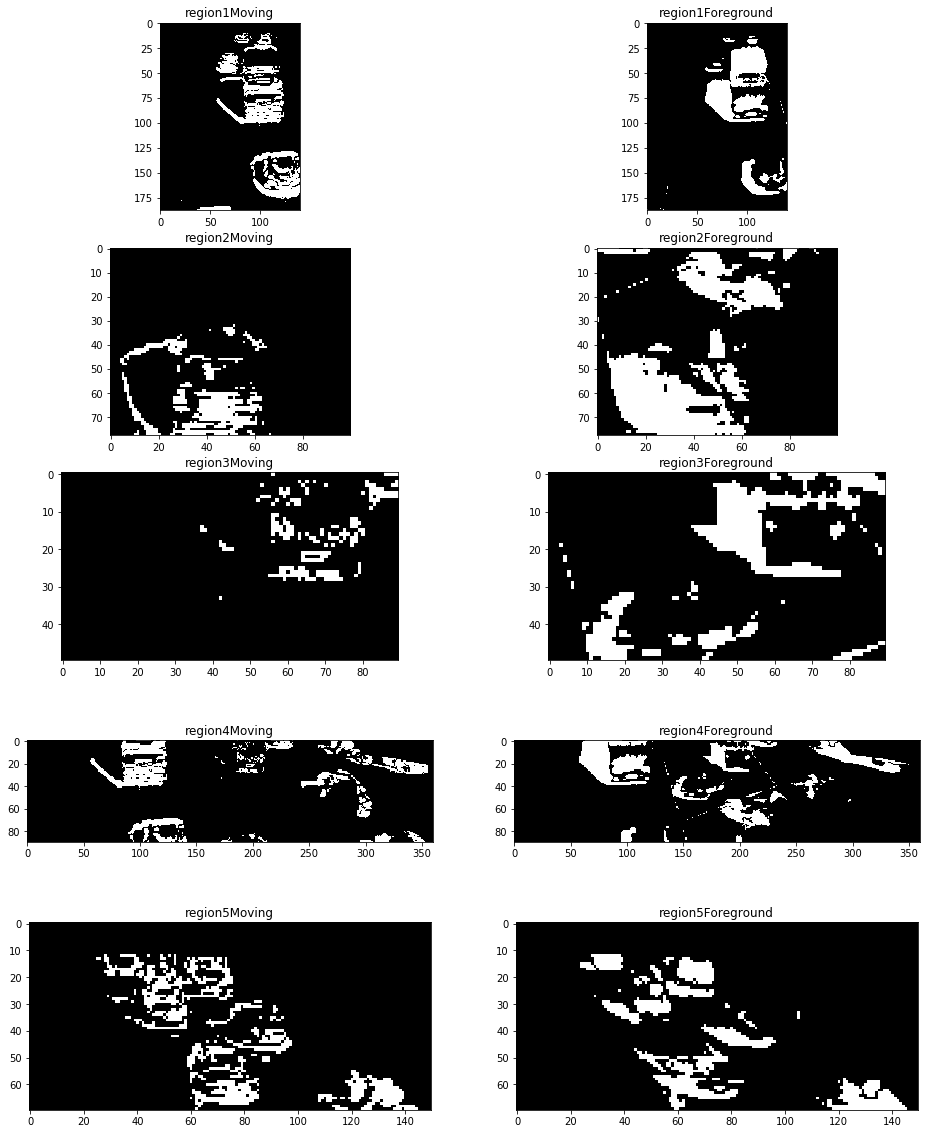

In [11]:
fig, ((ax1,ax2) , (ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5,2)
fig.set_size_inches(16,20)

ax1.imshow(region1_moving, 'gray')
ax2.imshow(region1_foreground, 'gray')

ax3.imshow(region2_moving, 'gray')
ax4.imshow(region2_foreground, 'gray')

ax5.imshow(region3_moving, 'gray')
ax6.imshow(region3_foreground, 'gray')

ax7.imshow(region4_moving, 'gray')
ax8.imshow(region4_foreground, 'gray')

ax9.imshow(region5_moving, 'gray')
ax10.imshow(region5_foreground, 'gray')

ax1.set_title("region1Moving")
ax2.set_title("region1Foreground")

ax3.set_title("region2Moving")
ax4.set_title("region2Foreground")

ax5.set_title("region3Moving")
ax6.set_title("region3Foreground")

ax7.set_title("region4Moving")
ax8.set_title("region4Foreground")

ax9.set_title("region5Moving")
ax10.set_title("region5Foreground")


OUTGOING MOVING: 34
OUTGOING STOPPED: -1

OUTGOING UTURN MOVING: 22
OUTGOING UTURN STOPPED: 43

INCOMING UTURN MOVING: 11
INCOMING UTURN STOPPED: 31

CROSSROAD MOVING: 26
CROSSROAD STOPPED: 5

INCOMING MOVING: 25
INCOMING STOPPED: 0



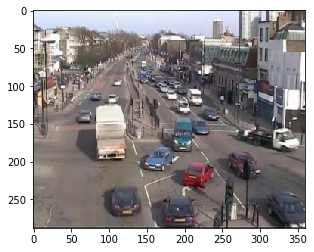

In [12]:
r1_moving_score = img_get_avg(region1_moving)
r1_stopped_score = img_get_avg(region1_foreground) - r1_moving_score # foreground includes moving cars

r2_moving_score = img_get_avg(region2_moving)
r2_stopped_score = img_get_avg(region2_foreground) - r2_moving_score

r3_moving_score = img_get_avg(region3_moving)
r3_stopped_score = img_get_avg(region3_foreground) - r3_moving_score

r4_moving_score = img_get_avg(region4_moving)
r4_stopped_score = img_get_avg(region4_foreground) - r4_moving_score

r5_moving_score = img_get_avg(region5_moving)
r5_stopped_score = img_get_avg(region5_foreground) - r5_moving_score

plt.imshow(frame1)


print("OUTGOING MOVING: %d" % r1_moving_score)
print("OUTGOING STOPPED: %d\n" % r1_stopped_score)

print("OUTGOING UTURN MOVING: %d" % r2_moving_score)
print("OUTGOING UTURN STOPPED: %d\n" % r2_stopped_score)

print("INCOMING UTURN MOVING: %d" % r3_moving_score)
print("INCOMING UTURN STOPPED: %d\n" % r3_stopped_score)

print("CROSSROAD MOVING: %d" % r4_moving_score)
print("CROSSROAD STOPPED: %d\n" % r4_stopped_score)

print("INCOMING MOVING: %d" % r5_moving_score)
print("INCOMING STOPPED: %d\n" % r5_stopped_score)

# Observations
- Outgoing region of interest had a total score of zero, conforms with the traffic snapshot used
- Outgoing Uturn recorded a high score even though no cars are in the outgoing uturn. However, the car moving in crossroad is passing through the outgoing uturn region, therefore in finding a decision, crossroad score will be subtracted from uturn regions during state 3 only to prevent the error occuring from region overlap
- Crossroad moving has a non-zero score